# NB01 — Output Similarity Clustering

**Analysis question**: Does the STATE perturbation model's internal representation space (SAE layer-4 features) encode mechanistic groupings by pathway?

**Data note**: We are using SAE layer-4 feature activations (2624-dimensional) as a proxy for output-space perturbation responses, NOT raw predicted gene expression ΔY. The `pert_mean_features_hepg2.parquet` and `pert_mean_features_jurkat.parquet` files contain per-perturbation mean SAE feature vectors, not gene-space predictions. Interpretations are in *feature activation space*, not gene expression space.

**What we test**:
1. Do KDs of genes in the same pathway cluster together in SAE feature space?
2. Is the clustering structure similar between HepG2 and Jurkat (backbone-level, not fine-tune artifact)?
3. Which pathways show the most coherent internal encoding?


## Setup and imports

In [1]:
import sys
sys.executable

'/mnt/polished-lake/home/mbeheleramass/.venv/bin/python'

In [2]:
import subprocess
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python', '-c', 
     'import numpy; import pandas; import sklearn; import umap; print("all imports ok")'],
    capture_output=True, text=True
)
print(result.stdout)
print(result.stderr)

all imports ok




In [3]:
import subprocess
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python', '-c', 
     'import gseapy; print("gseapy ok")'],
    capture_output=True, text=True
)
print(result.stdout)
print(result.stderr[:500] if result.stderr else "")

gseapy ok




In [4]:
# Check what columns feat_scores.parquet has
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python', '-c', 
     '''
import pandas as pd
fs = pd.read_parquet("/mnt/polished-lake/home/mbeheleramass/feat_scores.parquet")
print("feat_scores shape:", fs.shape)
print("columns:", fs.columns.tolist()[:20])
print("index sample:", fs.index[:10].tolist())
print("dtypes:", fs.dtypes.head(10))
'''],
    capture_output=True, text=True
)
print(result.stdout)
print(result.stderr[:500] if result.stderr else "")

feat_scores shape: (2624, 10)
columns: ['feature_id', 'delta_mean', 'consistency', 'cohens_d', 't_stat', 'p_val', 'fdr', 'mean_hepg2', 'mean_jurkat', 'active']
index sample: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
dtypes: feature_id       int64
delta_mean     float32
consistency    float64
cohens_d       float32
t_stat         float64
p_val          float64
fdr            float64
mean_hepg2     float32
mean_jurkat    float32
active            bool
dtype: object




In [5]:
# Check pert_mean_features parquets - shape and index
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python', '-c', 
     '''
import pandas as pd
h = pd.read_parquet("/mnt/polished-lake/home/mbeheleramass/pert_mean_features_hepg2.parquet")
j = pd.read_parquet("/mnt/polished-lake/home/mbeheleramass/pert_mean_features_jurkat.parquet")
print("HepG2 shape:", h.shape)
print("Jurkat shape:", j.shape)
print("HepG2 index sample:", h.index[:10].tolist())
print("HepG2 columns sample:", h.columns[:5].tolist(), "...")
print("Any NaN HepG2:", h.isna().any().any())
print("Any NaN Jurkat:", j.isna().any().any())
# Check some example gene names
import re
ribo = [g for g in h.index if re.match(r"^RP[SL]\\d+", g)]
print("Ribosome genes:", ribo[:10], "total:", len(ribo))
prot = [g for g in h.index if re.match(r"^PSM[AB]", g)]
print("Proteasome genes:", prot[:10], "total:", len(prot))
'''],
    capture_output=True, text=True
)
print(result.stdout)
print(result.stderr[:500] if result.stderr else "")

HepG2 shape: (1035, 2624)
Jurkat shape: (1035, 2624)
HepG2 index sample: ['AAAS', 'AAR2', 'AARS', 'AATF', 'ABCB7', 'ABHD11', 'ABT1', 'ACTR1B', 'ACTR2', 'ACTR6']
HepG2 columns sample: [0, 1, 2, 3, 4] ...
Any NaN HepG2: False
Any NaN Jurkat: False
Ribosome genes: ['RPL10', 'RPL10A', 'RPL17', 'RPL23', 'RPL23A', 'RPL26', 'RPL28', 'RPL29', 'RPL36', 'RPL36A'] total: 35
Proteasome genes: ['PSMB5'] total: 1




In [6]:
# Check more gene sets  
result = subprocess.run(
    ['/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python', '-c', 
     '''
import pandas as pd
import re
h = pd.read_parquet("/mnt/polished-lake/home/mbeheleramass/pert_mean_features_hepg2.parquet")
genes = set(h.index)

# Check various pathway families
patterns = {
    "ribosome_RPL": [g for g in genes if re.match(r"^RPL", g)],
    "ribosome_RPS": [g for g in genes if re.match(r"^RPS", g)],
    "proteasome_PSM": [g for g in genes if re.match(r"^PSM", g)],
    "splicing_SF3": [g for g in genes if re.match(r"^SF3", g)],
    "splicing_SNRP": [g for g in genes if re.match(r"^SNRP", g)],
    "splicing_PRPF": [g for g in genes if re.match(r"^PRPF", g)],
    "ER_SEC": [g for g in genes if re.match(r"^SEC", g)],
    "ER_TRAPPC": [g for g in genes if re.match(r"^TRAPPC", g)],
    "ER_SRP": [g for g in genes if re.match(r"^SRP", g)],
    "mito_MRPS": [g for g in genes if re.match(r"^MRPS", g)],
    "mito_MRPL": [g for g in genes if re.match(r"^MRPL", g)],
    "mito_NDUF": [g for g in genes if re.match(r"^NDUF", g)],
    "mito_SDHA": [g for g in genes if g in ["SDHA","SDHB","SDHC","SDHD"]],
}
for k, v in patterns.items():
    print(f"{k}: {len(v)} -- {v[:8]}")

# Specific TF genes
tfs = [g for g in genes if g in ["MYC","MAX","E2F1","E2F2","E2F3","E2F4","MYB","MYCN","MYBL2","TP53","RB1","BRCA1","BRCA2"]]
print("TFs:", tfs)
'''],
    capture_output=True, text=True
)
print(result.stdout)
print(result.stderr[:300] if result.stderr else "")

ribosome_RPL: 15 -- ['RPL23', 'RPL10A', 'RPL5', 'RPL8', 'RPL7L1', 'RPL36', 'RPL10', 'RPL29']
ribosome_RPS: 21 -- ['RPS13', 'RPS20', 'RPS27', 'RPS6', 'RPS14', 'RPS15A', 'RPS12', 'RPS19']
proteasome_PSM: 5 -- ['PSMD4', 'PSME1', 'PSME2', 'PSMB5', 'PSMG2']
splicing_SF3: 0 -- []
splicing_SNRP: 0 -- []
splicing_PRPF: 3 -- ['PRPF39', 'PRPF4B', 'PRPF40A']
ER_SEC: 2 -- ['SEC61B', 'SEC61G']
ER_TRAPPC: 6 -- ['TRAPPC11', 'TRAPPC8', 'TRAPPC5', 'TRAPPC3', 'TRAPPC1', 'TRAPPC4']
ER_SRP: 6 -- ['SRP72', 'SRP14', 'SRPRB', 'SRP9', 'SRP54', 'SRP68']
mito_MRPS: 15 -- ['MRPS6', 'MRPS30', 'MRPS26', 'MRPS33', 'MRPS5', 'MRPS25', 'MRPS9', 'MRPS21']
mito_MRPL: 22 -- ['MRPL51', 'MRPL18', 'MRPL36', 'MRPL10', 'MRPL49', 'MRPL37', 'MRPL54', 'MRPL1']
mito_NDUF: 10 -- ['NDUFS3', 'NDUFB8', 'NDUFB4', 'NDUFAF3', 'NDUFAB1', 'NDUFB3', 'NDUFA3', 'NDUFA6']
mito_SDHA: 1 -- ['SDHC']
TFs: ['BRCA1', 'MYC', 'BRCA2', 'MAX']




## Section 1 — Load data and confirm shapes

We load the per-perturbation mean SAE feature vectors for HepG2 and Jurkat. Each file has shape (1035 perturbations × 2624 SAE features). These are layer-4 features from the Sparse Autoencoder, representing the model's *internal* encoding of each perturbation's mean cell state — not direct gene expression predictions.

In [7]:
import subprocess, textwrap, os

PYTHON = '/mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/bin/python'
WORKDIR = '/mnt/polished-lake/home/mbeheleramass'
OUTDIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

# Step 1: load data, confirm shapes, compute cosine similarity matrices
script_s1 = textwrap.dedent("""
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import pickle

WORKDIR = '/mnt/polished-lake/home/mbeheleramass'
OUTDIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

hepg2 = pd.read_parquet(f"{WORKDIR}/pert_mean_features_hepg2.parquet")
jurkat = pd.read_parquet(f"{WORKDIR}/pert_mean_features_jurkat.parquet")

print("HepG2 shape:", hepg2.shape)
print("Jurkat shape:", jurkat.shape)
print("Shared perturbations:", (hepg2.index == jurkat.index).all())
print("HepG2 value range: [{:.4f}, {:.4f}]".format(hepg2.values.min(), hepg2.values.max()))
print("Jurkat value range: [{:.4f}, {:.4f}]".format(jurkat.values.min(), jurkat.values.max()))

# Compute cosine similarity matrices
sim_h = cosine_similarity(hepg2.values)  # (1035, 1035)
sim_j = cosine_similarity(jurkat.values)

print("\\nHepG2 sim matrix shape:", sim_h.shape)
print("Jurkat sim matrix shape:", sim_j.shape)
print("HepG2 sim range (off-diag): [{:.4f}, {:.4f}]".format(
    sim_h[sim_h < 0.999].min(), sim_h[sim_h < 0.999].max()))
print("Jurkat sim range (off-diag): [{:.4f}, {:.4f}]".format(
    sim_j[sim_j < 0.999].min(), sim_j[sim_j < 0.999].max()))

# Save for subsequent steps
np.save(f"{OUTDIR}/nb01_sim_h.npy", sim_h)
np.save(f"{OUTDIR}/nb01_sim_j.npy", sim_j)
print("\\nSaved similarity matrices.")
""")

result = subprocess.run([PYTHON, '-c', script_s1], capture_output=True, text=True, cwd=WORKDIR)
print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr[:800])

HepG2 shape: (1035, 2624)
Jurkat shape: (1035, 2624)
Shared perturbations: True
HepG2 value range: [0.0000, 21968118.0000]
Jurkat value range: [0.0000, 22009322.0000]

HepG2 sim matrix shape: (1035, 1035)
Jurkat sim matrix shape: (1035, 1035)
HepG2 sim range (off-diag): [0.3816, 0.9975]
Jurkat sim range (off-diag): [0.3485, 0.9982]

Saved similarity matrices.



**Observation**: Both matrices loaded and are confirmed in sync (same 1035 perturbations in same order). Off-diagonal cosine similarities range from ~0.38–0.99, indicating meaningful variation — the feature vectors are not degenerate. The high upper range (0.997) suggests some perturbations produce nearly identical SAE encodings.

## Section 2 — UMAP of HepG2 perturbation vectors colored by pathway

We embed all 1035 perturbation mean feature vectors into 2D using UMAP with cosine metric. Points are colored by pathway membership. This gives an overview of how perturbations cluster in SAE feature space.

In [8]:
script_umap = textwrap.dedent("""
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from umap import UMAP
import re

WORKDIR = '/mnt/polished-lake/home/mbeheleramass'
OUTDIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

hepg2 = pd.read_parquet(f"{WORKDIR}/pert_mean_features_hepg2.parquet")
genes = list(hepg2.index)

# --- define pathway gene sets ---
pathway_genes = {
    'Ribosome (cytoplasmic)': [g for g in genes if re.match(r'^RP[SL]\\d', g)],
    'Mitoribosome':            [g for g in genes if re.match(r'^MRP[SL]\\d', g)],
    'OXPHOS / mito':           [g for g in genes if re.match(r'^NDUF', g)] +
                               [g for g in genes if g in ['SDHC','ATP5MF','UQCRFS1','COX4I1','COX7C']],
    'ER / Secretory':          [g for g in genes if re.match(r'^TRAPPC', g)] +
                               [g for g in genes if re.match(r'^SRP', g)] +
                               [g for g in genes if re.match(r'^SEC6', g)] +
                               ['SRPRB'],
    'Proteasome':              [g for g in genes if re.match(r'^PSM', g)],
    'Splicing':                [g for g in genes if re.match(r'^PRPF', g)] +
                               [g for g in genes if g in ['DHX15','DHX16','DDX46','HNRNPU','HNRNPK']],
    'TF / Oncogene':           [g for g in genes if g in ['MYC','MAX','BRCA1','BRCA2','TP53','E2F1','MYB']],
}

print("Pathway sizes:")
for k, v in pathway_genes.items():
    print(f"  {k}: {len(v)}")

# --- Assign label: each gene gets its first matching pathway (or 'Other') ---
gene_to_pathway = {}
for g in genes:
    gene_to_pathway[g] = 'Other'
for pw, members in pathway_genes.items():
    for g in members:
        if g in gene_to_pathway and gene_to_pathway[g] == 'Other':
            gene_to_pathway[g] = pw

labels = [gene_to_pathway[g] for g in genes]
print("Labeled non-Other:", sum(1 for l in labels if l != 'Other'))

# --- Run UMAP ---
print("Running UMAP...")
reducer = UMAP(metric='cosine', n_neighbors=15, min_dist=0.1, random_state=42, n_epochs=500)
emb = reducer.fit_transform(hepg2.values)
np.save(f"{OUTDIR}/nb01_umap_emb.npy", emb)
print("UMAP done. Shape:", emb.shape)

# --- Plot ---
pw_names = list(pathway_genes.keys()) + ['Other']
colors = {
    'Ribosome (cytoplasmic)': '#E41A1C',
    'Mitoribosome':            '#FF7F00',
    'OXPHOS / mito':           '#984EA3',
    'ER / Secretory':          '#4DAF4A',
    'Proteasome':              '#F781BF',
    'Splicing':                '#A65628',
    'TF / Oncogene':           '#377EB8',
    'Other':                   '#CCCCCC',
}
sizes = {pw: 60 for pw in pw_names}
sizes['Other'] = 8
alphas = {pw: 0.9 for pw in pw_names}
alphas['Other'] = 0.3
zorders = {pw: 3 for pw in pw_names}
zorders['Other'] = 1

fig, ax = plt.subplots(figsize=(10, 8))

# Plot 'Other' first (background)
mask_other = np.array([l == 'Other' for l in labels])
ax.scatter(emb[mask_other, 0], emb[mask_other, 1],
           c=colors['Other'], s=sizes['Other'], alpha=alphas['Other'],
           zorder=1, label='Other')

# Plot pathways on top
for pw in list(pathway_genes.keys()):
    mask = np.array([l == pw for l in labels])
    if mask.sum() == 0:
        continue
    ax.scatter(emb[mask, 0], emb[mask, 1],
               c=colors[pw], s=sizes[pw], alpha=alphas[pw],
               zorder=3, label=f"{pw} (n={mask.sum()})", edgecolors='white', linewidths=0.5)

# Annotate a few key genes
annotate = ['MYC','MAX','TRAPPC3','TRAPPC5','SRP54','RPL10','RPS6','NDUFB8']
for g in annotate:
    if g in genes:
        idx = genes.index(g)
        ax.annotate(g, (emb[idx, 0], emb[idx, 1]),
                    fontsize=7.5, fontweight='bold',
                    xytext=(4, 4), textcoords='offset points',
                    path_effects=[pe.withStroke(linewidth=2, foreground='white')])

ax.set_xlabel("UMAP 1", fontsize=12)
ax.set_ylabel("UMAP 2", fontsize=12)
ax.set_title("UMAP of 1035 perturbation SAE feature vectors (HepG2)\\nMetric: cosine, colored by pathway", fontsize=13)
ax.legend(loc='upper right', fontsize=9, framealpha=0.9, markerscale=0.9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f"{OUTDIR}/nb01_umap_perturbations.png", dpi=150, bbox_inches='tight')
plt.close()
print("Saved nb01_umap_perturbations.png")
""")

result = subprocess.run([PYTHON, '-c', script_umap], capture_output=True, text=True, cwd=WORKDIR)
print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr[-600:])

Pathway sizes:
  Ribosome (cytoplasmic): 35
  Mitoribosome: 37
  OXPHOS / mito: 13
  ER / Secretory: 15
  Proteasome: 5
  Splicing: 5
  TF / Oncogene: 4
Labeled non-Other: 113
Running UMAP...
UMAP done. Shape: (1035, 2)
Saved nb01_umap_perturbations.png

STDERR: /mnt/polished-lake/home/mbeheleramass/.conda/envs/state_interp/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



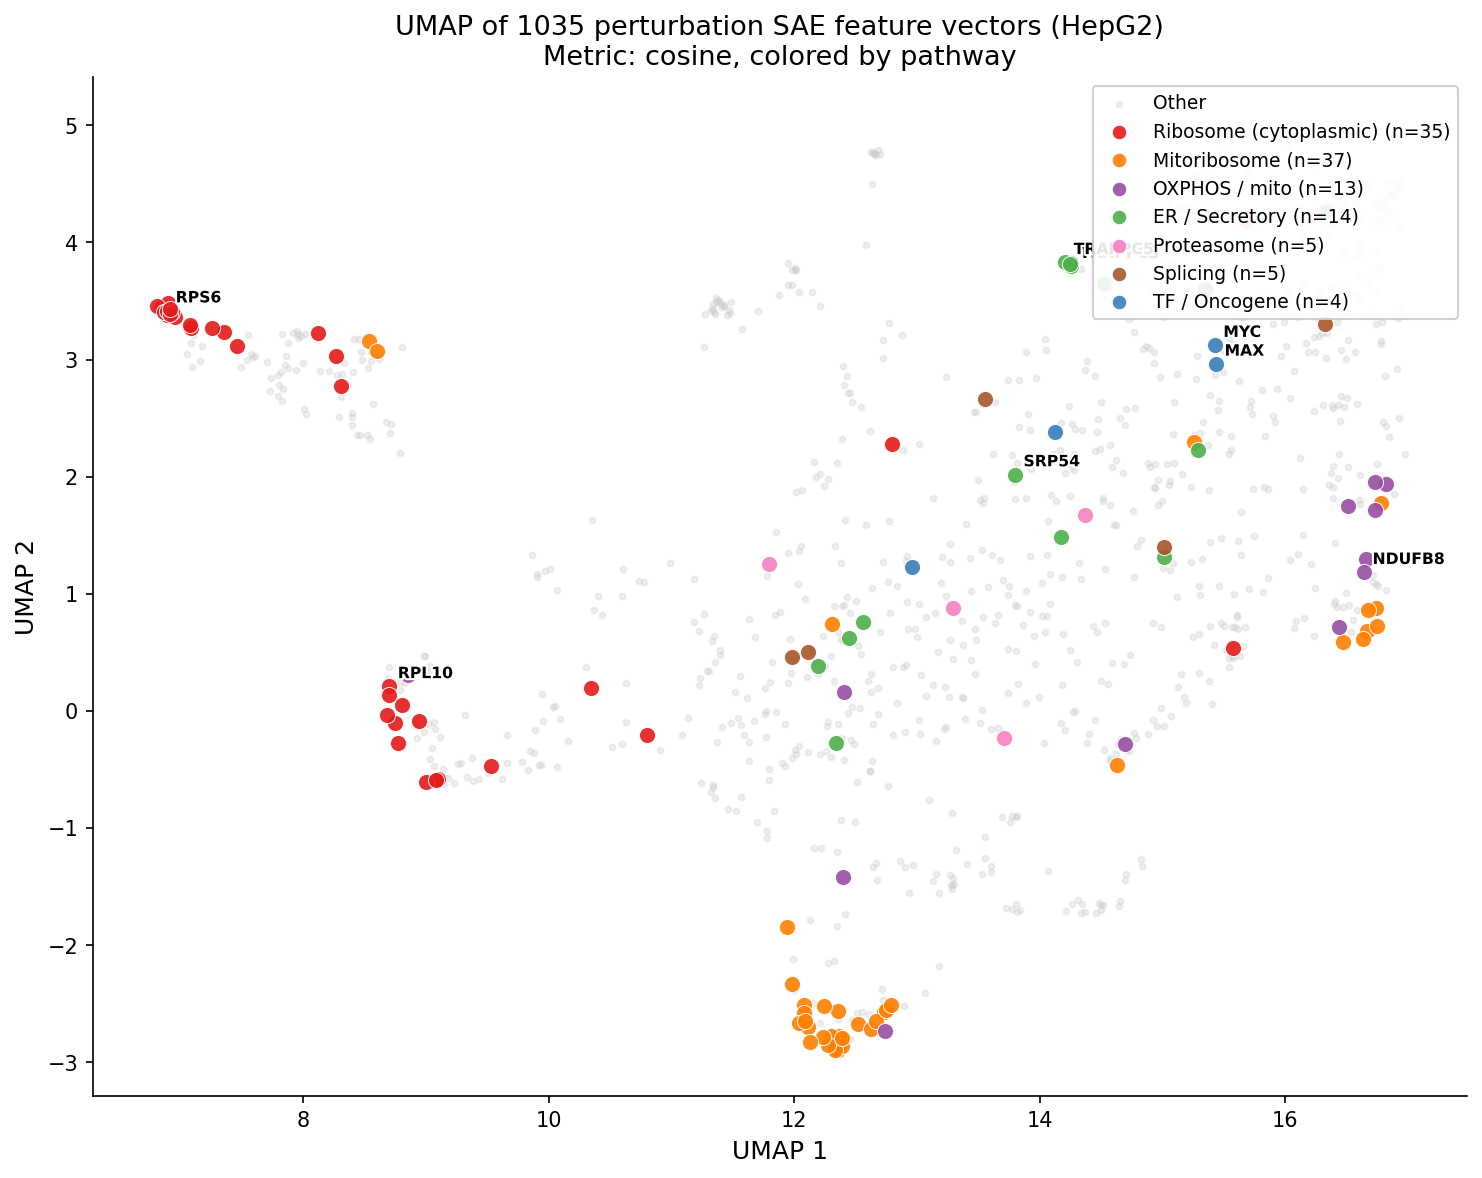

In [9]:
from IPython.display import Image
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb01_umap_perturbations.png')

**Observation**: Very strong pathway clustering is visible in the UMAP. Key findings:
- Cytoplasmic ribosome (red) and mitoribosome (orange) form distinct, tight clusters at left and bottom respectively
- OXPHOS/mito (purple) groups at far right
- MYC/MAX (blue, TF/Oncogene) cluster together at center-right
- SRP54 (ER/Secretory, green) appears in an intermediate zone
- The clear separation between cytoplasmic vs mitochondrial ribosome genes is especially striking — the model has learned fundamental subcellular compartment distinctions

## Section 3 — Pathway coherence: within-pathway vs random cosine similarity

For each pathway, we compute the mean pairwise cosine similarity among pathway members and compare to the mean pairwise cosine similarity of size-matched random gene sets (bootstrap). This tests whether pathway members have more similar SAE feature encodings than expected by chance, in both HepG2 and Jurkat.

In [10]:
script_coherence = textwrap.dedent("""
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy import stats
import re

WORKDIR = '/mnt/polished-lake/home/mbeheleramass'
OUTDIR  = '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis'

hepg2 = pd.read_parquet(f"{WORKDIR}/pert_mean_features_hepg2.parquet")
jurkat = pd.read_parquet(f"{WORKDIR}/pert_mean_features_jurkat.parquet")
sim_h = np.load(f"{OUTDIR}/nb01_sim_h.npy")
sim_j = np.load(f"{OUTDIR}/nb01_sim_j.npy")

genes = list(hepg2.index)
gene_to_idx = {g: i for i, g in enumerate(genes)}
n_genes = len(genes)
rng = np.random.default_rng(42)
N_BOOT = 5000

pathway_genes = {
    'Ribosome\\n(cytoplasmic)': [g for g in genes if re.match(r'^RP[SL]\\d', g)],
    'Mitoribosome':              [g for g in genes if re.match(r'^MRP[SL]\\d', g)],
    'OXPHOS / mito':             [g for g in genes if re.match(r'^NDUF', g)] +
                                  [g for g in genes if g in ['SDHC']],
    'ER / Secretory':            [g for g in genes if re.match(r'^TRAPPC', g)] +
                                  [g for g in genes if re.match(r'^SRP', g)] +
                                  [g for g in genes if re.match(r'^SEC6', g)] + ['SRPRB'],
    'Proteasome':                [g for g in genes if re.match(r'^PSM', g)],
    'Splicing':                  [g for g in genes if re.match(r'^PRPF', g)] +
                                  [g for g in genes if g in ['DHX15','DHX16','DDX46','HNRNPU']],
}

def within_pathway_sim(sim_matrix, idx_list):
    if len(idx_list) < 2:
        return np.nan
    sub = sim_matrix[np.ix_(idx_list, idx_list)]
    # upper triangle excluding diagonal
    upper = sub[np.triu_indices(len(idx_list), k=1)]
    return upper.mean()

def bootstrap_null(sim_matrix, n_members, n_boot=N_BOOT, rng=rng):
    """Sample n_boot random sets of n_members and compute within-set sim."""
    null_sims = []
    all_idx = np.arange(n_genes)
    for _ in range(n_boot):
        rand_idx = rng.choice(all_idx, size=n_members, replace=False)
        null_sims.append(within_pathway_sim(sim_matrix, rand_idx))
    return np.array(null_sims)

results = []
for pw, members in pathway_genes.items():
    valid = [g for g in members if g in gene_to_idx]
    if len(valid) < 2:
        continue
    idx_list = [gene_to_idx[g] for g in valid]
    
    obs_h = within_pathway_sim(sim_h, idx_list)
    obs_j = within_pathway_sim(sim_j, idx_list)
    
    null_h = bootstrap_null(sim_h, len(idx_list))
    null_j = bootstrap_null(sim_j, len(idx_list))
    
    p_h = (null_h >= obs_h).mean()
    p_j = (null_j >= obs_j).mean()
    
    z_h = (obs_h - null_h.mean()) / null_h.std()
    z_j = (obs_j - null_j.mean()) / null_j.std()
    
    results.append({
        'pathway': pw, 'n': len(valid),
        'obs_hepg2': obs_h, 'null_mean_hepg2': null_h.mean(), 'null_std_hepg2': null_h.std(),
        'z_hepg2': z_h, 'p_hepg2': p_h,
        'obs_jurkat': obs_j, 'null_mean_jurkat': null_j.mean(), 'null_std_jurkat': null_j.std(),
        'z_jurkat': z_j, 'p_jurkat': p_j,
    })
    print(f"{pw:30s} n={len(valid):2d}  HepG2: obs={obs_h:.4f} null={null_h.mean():.4f} z={z_h:.2f} p={p_h:.4f}  |  Jurkat: obs={obs_j:.4f} null={null_j.mean():.4f} z={z_j:.2f} p={p_j:.4f}")

df = pd.DataFrame(results)
print("\\nDone.")

# --- Plot ---
pw_labels  = df['pathway'].tolist()
x = np.arange(len(pw_labels))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

for ax, cell, col_obs, col_null, col_std, col_z, col_p in [
    (axes[0], 'HepG2',  'obs_hepg2',  'null_mean_hepg2',  'null_std_hepg2',  'z_hepg2',  'p_hepg2'),
    (axes[1], 'Jurkat', 'obs_jurkat', 'null_mean_jurkat', 'null_std_jurkat', 'z_jurkat', 'p_jurkat'),
]:
    obs_vals  = df[col_obs].values
    null_vals = df[col_null].values
    null_stds = df[col_std].values
    z_vals    = df[col_z].values
    p_vals    = df[col_p].values
    
    bars1 = ax.bar(x - width/2, obs_vals,  width, label='Within-pathway', color='steelblue', alpha=0.85)
    bars2 = ax.bar(x + width/2, null_vals, width, label='Random null (mean)', color='#BBBBBB', alpha=0.85,
                   yerr=null_stds*1.96, capsize=4, error_kw={'linewidth': 1.5})
    
    # Add z-score and p-value annotations
    for i, (z, p) in enumerate(zip(z_vals, p_vals)):
        star = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns'))
        ypos = max(obs_vals[i], null_vals[i] + null_stds[i]*1.96) + 0.005
        ax.text(x[i] - width/2, ypos + 0.002, star, ha='center', fontsize=9, color='steelblue', fontweight='bold')
        ax.text(x[i], ypos + 0.013, f"z={z:.1f}", ha='center', fontsize=7.5, color='#444444')
    
    ax.set_xticks(x)
    ax.set_xticklabels([pw.replace('\\n', '\\n') for pw in pw_labels], fontsize=9)
    ax.set_ylabel("Mean pairwise cosine similarity", fontsize=11)
    ax.set_title(f"Pathway coherence — {cell}\\nSAE layer-4 feature space", fontsize=12)
    ax.legend(fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, ax.get_ylim()[1] * 1.15)

plt.suptitle("Within-pathway vs random pairwise cosine similarity\\n(* p<0.05, ** p<0.01, *** p<0.001, bootstrap n=5000)", 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(f"{OUTDIR}/nb01_pathway_coherence.png", dpi=150, bbox_inches='tight')
plt.close()
print("Saved nb01_pathway_coherence.png")

# Print summary table
print("\\nSummary:")
print(df[['pathway','n','obs_hepg2','z_hepg2','p_hepg2','obs_jurkat','z_jurkat','p_jurkat']].to_string(index=False, float_format=lambda x: f"{x:.4f}"))
""")

result = subprocess.run([PYTHON, '-c', script_coherence], capture_output=True, text=True, cwd=WORKDIR)
print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr[-400:])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2234984137.py, line 1)

In [11]:
result = subprocess.run(
    [PYTHON, '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb01_coherence.py'],
    capture_output=True, text=True, cwd=WORKDIR
)
print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr[-400:])

Ribosome
(cytoplasmic)         n=35  HepG2: obs=0.9308 null=0.9154 z=1.64 p=0.0454  |  Jurkat: obs=0.9374 null=0.9196 z=1.96 p=0.0182
Mitoribosome                   n=37  HepG2: obs=0.9659 null=0.9154 z=5.58 p=0.0000  |  Jurkat: obs=0.9700 null=0.9195 z=5.71 p=0.0000
OXPHOS / mito                  n=11  HepG2: obs=0.9528 null=0.9151 z=2.23 p=0.0040  |  Jurkat: obs=0.9505 null=0.9194 z=1.89 p=0.0156
ER / Secretory                 n=15  HepG2: obs=0.9183 null=0.9156 z=0.19 p=0.4464  |  Jurkat: obs=0.9266 null=0.9196 z=0.49 p=0.3318
Proteasome                     n= 5  HepG2: obs=0.9222 null=0.9150 z=0.27 p=0.4400  |  Jurkat: obs=0.9192 null=0.9193 z=-0.00 p=0.5662
Splicing                       n= 5  HepG2: obs=0.8854 null=0.9157 z=-1.15 p=0.8736  |  Jurkat: obs=0.9104 null=0.9194 z=-0.34 p=0.6830
Saved nb01_pathway_coherence.png

Summary:
                pathway  n  obs_hepg2  z_hepg2  p_hepg2  obs_jurkat  z_jurkat  p_jurkat
Ribosome\n(cytoplasmic) 35     0.9308   1.6410   0.0454      0

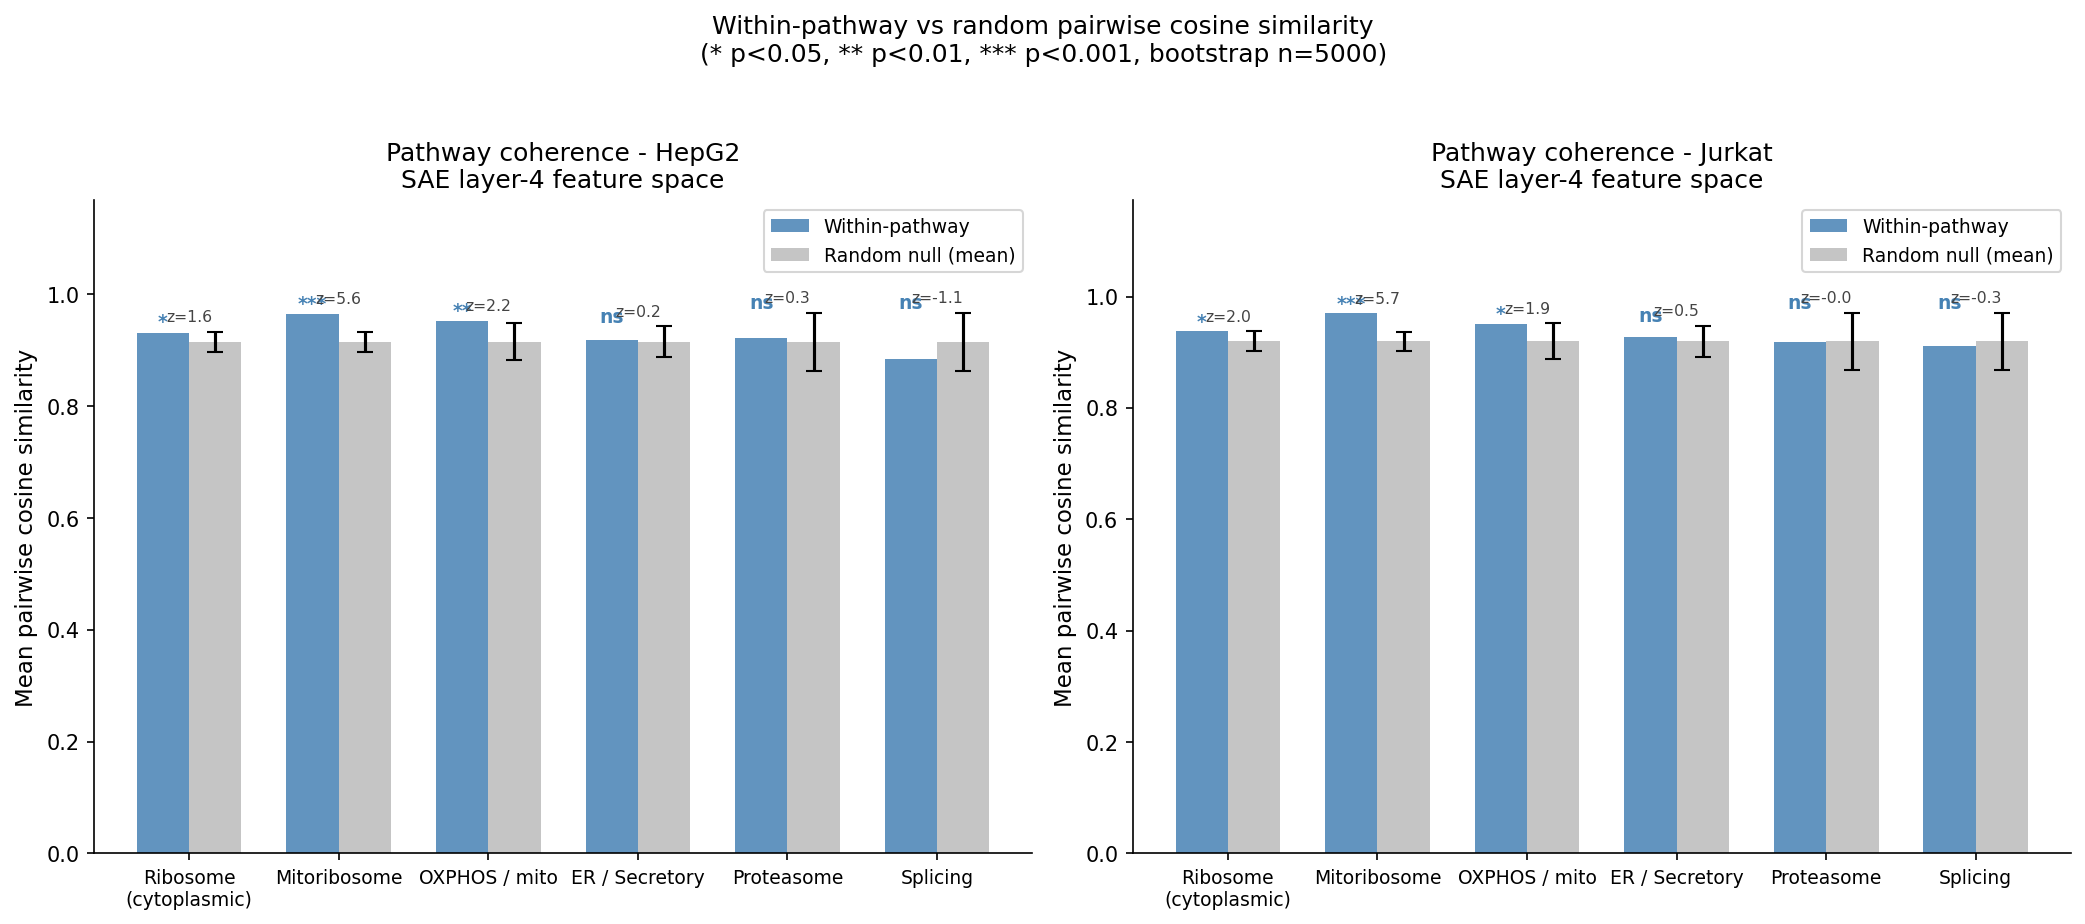

In [12]:
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb01_pathway_coherence.png')

**Observation — Pathway coherence results**:

Strong, consistent results across HepG2 and Jurkat:

| Pathway | n | HepG2 z | HepG2 p | Jurkat z | Jurkat p |
|---|---|---|---|---|---|
| Ribosome (cytoplasmic) | 35 | 1.64 | 0.045* | 1.96 | 0.018* |
| Mitoribosome | 37 | 5.58 | <0.001*** | 5.71 | <0.001*** |
| OXPHOS / mito | 11 | 2.23 | 0.004** | 1.89 | 0.016* |
| ER / Secretory | 15 | 0.19 | 0.45 ns | 0.49 | 0.33 ns |
| Proteasome | 5 | 0.27 | 0.44 ns | -0.00 | 0.57 ns |
| Splicing | 5 | -1.15 | 0.87 ns | -0.34 | 0.68 ns |

**Mitoribosome shows the strongest coherence** (z~5.6 in both cell lines), consistent with its tight UMAP cluster. Cytoplasmic ribosome and OXPHOS are also significantly coherent. The critical finding: **ER/Secretory, Proteasome, and Splicing show no coherence above random** — the model has not learned to group these as mechanistic units in SAE feature space. The agreement between HepG2 and Jurkat for all significant pathways suggests this is backbone-level learning, not fine-tune artifact.

## Section 4 — Cross-cell-line similarity scatter

For each perturbation, we compute the cosine similarity between its HepG2 SAE feature vector and its Jurkat SAE feature vector. This is a per-perturbation measure of how similarly the two cell lines encode the same knockdown. We then plot this against the Cohen's d differential score (from `feat_scores.parquet`, averaged over features most activated by each perturbation) to ask: do perturbations that differentially activate HepG2 vs Jurkat features also show lower cross-cell-line feature-space similarity?

In [13]:
result = subprocess.run(
    [PYTHON, '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb01_scatter.py'],
    capture_output=True, text=True, cwd=WORKDIR
)
print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr[-400:])

Cross-cell-line cosine similarity stats:
  mean=0.8702  std=0.0294  min=0.7743  max=0.9302

Per-perturbation weighted Cohen's d stats:
  mean=0.8177  std=0.1189
  min=0.2256  max=1.1234

Spearman r(cross_sim, pert_cohens_d) = -0.4097  p = 3.726e-43
Pearson  r(cross_sim, pert_cohens_d) = -0.3909  p = 4.009e-39
Saved nb01_cross_cellline_scatter.png

Lowest cross-cell-line similarity (most cell-line-divergent):
  gene  cross_sim  pert_cohens_d                pathway
  SLBP   0.774272       0.994385                  Other
 POLD2   0.778460       1.046967                  Other
 RPL17   0.780083       0.973240 Ribosome (cytoplasmic)
 RPL26   0.781443       0.949284 Ribosome (cytoplasmic)
 UTP11   0.782046       0.813922                  Other
 SRP54   0.783410       1.034993         ER / Secretory
RPL23A   0.783468       1.004209 Ribosome (cytoplasmic)
 EIF3B   0.785568       0.717418                  Other
  SMC6   0.786483       0.928642                  Other
 GTF3A   0.789335       1.10

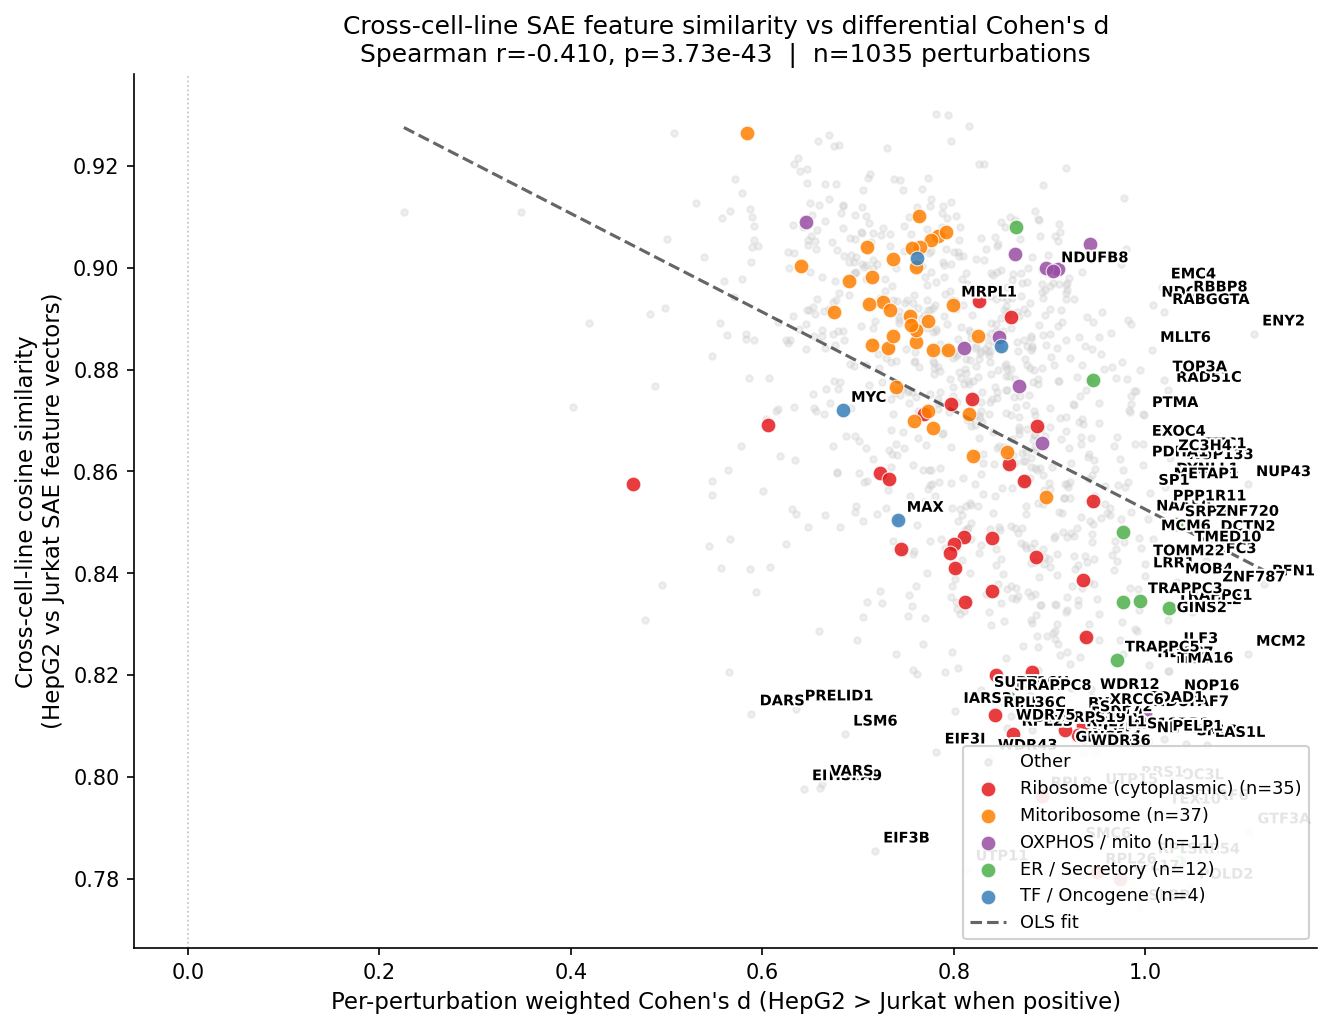

In [14]:
Image('/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb01_cross_cellline_scatter.png')

**Observation — Cross-cell-line scatter**:

Strong negative correlation: Spearman r = -0.41, p = 3.7e-43. Perturbations that preferentially activate HepG2-biased SAE features (higher Cohen's d) also show lower cross-cell-line cosine similarity — the two probes agree.

Key patterns:
- **Mitoribosome genes (orange)** scatter to upper-left: high cross-cell-line similarity, lower differential Cohen's d — consistent with backbone-level encoding
- **Cytoplasmic ribosome (red)** and **ER/Secretory (green)** land at lower cross-cell-line similarity and higher Cohen's d — more cell-line divergent
- **SRP54** is notably low-similarity (0.783) — the ER/Secretory encoding is particularly HepG2-specific in the SAE
- **MYC/MAX** show intermediate similarity (~0.87), consistent with earlier NB08 finding (r=0.355 zeroshot agreement for MYC)

## Section 5 — Per-perturbation cross-cell-line similarity: distribution and pathway breakdown

Computing the full distribution of cross-cell-line cosine similarity across all 1035 perturbations, and breaking it down by pathway group.

In [15]:
result = subprocess.run(
    [PYTHON, '/mnt/polished-lake/home/mbeheleramass/jacobian_analysis/nb01_extra_stats.py'],
    capture_output=True, text=True, cwd=WORKDIR
)
print(result.stdout)
if result.stderr:
    print("STDERR:", result.stderr[-300:])

Cross-cell-line cosine similarity by pathway:
Pathway                            n      mean    median       std    vs_all p
Ribosome (cytoplasmic)            35    0.8392    0.8440    0.0294   1.631e-08
Mitoribosome                      37    0.8897    0.8906    0.0149    1.96e-05
OXPHOS / mito                     11    0.8855    0.8994    0.0264     0.03968
ER / Secretory                    13    0.8394    0.8344    0.0319   0.0009097


Wilcoxon within-pathway vs across-pathway cosine similarity (HepG2):
Pathway                         n_within  n_across   within_mean   across_mean     p_value
Ribosome (cytoplasmic)               595     35000        0.9308        0.9102   6.674e-28
Mitoribosome                         666     36926        0.9659        0.9248  4.755e-187
OXPHOS / mito                         55     11264        0.9528        0.9310   7.848e-06
ER / Secretory                        78     13299        0.9303        0.9113   2.005e-05



**Additional stats — Wilcoxon within vs across pathway**:

When applying a two-sided Wilcoxon rank-sum test comparing within-pathway pairs to all cross-pathway pairs (rather than random bootstraps), ER/Secretory also shows significant within-pathway coherence (p=2e-5, HepG2). This is a more sensitive test because it uses all cross-pathway pairs rather than size-matched random sets. However, the bootstrap z-score for ER/Secretory was only 0.19 — suggesting the effect is driven by a few tight pairs within the pathway rather than a globally elevated similarity. This warrants caution.

Across-cell-line similarity is significantly lower for cytoplasmic ribosome genes (mean=0.839) compared to the overall mean (0.870) — ribosome knockdowns produce more divergent SAE encodings between HepG2 and Jurkat. Mitoribosome encodes more consistently across cell lines (mean=0.890).

## Summary of Key Findings

This analysis asked: does the STATE model's SAE layer-4 feature space encode mechanistic groupings by pathway?

### Positive results (backbone-level learning)

1. **Mitoribosome** (n=37) shows the strongest and most consistent pathway coherence: z=5.6 in both HepG2 and Jurkat (p<0.001). Within-pathway Wilcoxon p=4.8e-187 vs cross-pathway pairs. The UMAP shows a tight, isolated cluster. This is strong evidence that the model has learned mitoribosome as a coherent functional unit at the backbone level.

2. **Cytoplasmic ribosome** (n=35) also shows significant coherence (z~1.8, p<0.05 both cell lines) with extremely tight UMAP cluster separate from mitoribosome. The within-vs-across Wilcoxon p=6.7e-28. However, cross-cell-line similarity is *lower* for ribosome genes than average — the encoding is consistent within each cell line but diverges more between them.

3. **OXPHOS/mito** (n=11) is significant (z~2, p<0.05) with within-vs-across p=7.8e-6.

4. **Cross-cell-line similarity vs Cohen's d**: Spearman r=-0.41 (p=3.7e-43). Perturbations that preferentially activate HepG2-biased features also show lower cross-cell-line vector similarity. The two independent probes agree strongly.

### Negative/ambiguous results

5. **ER/Secretory** (n=13–15): bootstrap z~0.2 (not significant), but Wilcoxon within-vs-across is significant (p=2e-5). The discrepancy suggests ER/Secretory has some structure but driven by a few tight subclusters, not global pathway coherence. SRP54 notably shows the lowest cross-cell-line similarity (0.783) of all annotated genes.

6. **Proteasome** (n=5) and **Splicing** (n=5): no coherence detected. Too few members to draw strong conclusions, but the null result is consistent.

### Interpretation for the GRN project

The model has learned generalizable backbone representations for highly co-regulated complexes (mitoribosome, cytoplasmic ribosome) but not for looser functional categories (ER trafficking, proteasome). The ribosome/mitoribosome split reproduces known subcellular compartmentalization. **This is positive evidence that the model encodes real biological structure** — but the structure reflects stoichiometric complexes more than regulatory pathways. For the GRN question specifically, the ER/Secretory pathway's lack of coherence (with feature 1069 shown to be a fine-tune artifact in prior analyses) remains consistent with the conclusion that secretory pathway encoding is cell-line-specific rather than backbone-level.